<a href="https://colab.research.google.com/github/bombaybrew/colab_experiments/blob/master/quickdraw_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCE:

https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb
https://github.com/googlecreativelab/quickdraw-dataset

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   33G  50% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [77]:
!free -mh

              total        used        free      shared  buff/cache   available
Mem:            12G        3.2G        5.2G        964K        4.2G         11G
Swap:            0B          0B          0B


In [79]:
!nvidia-smi

Tue Jul 28 07:03:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!mkdir data

In [5]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  classes = ['apple','beach','book','bus','cake','car','clock','cloud','diamond','sun']
  # classes = ['airplane']
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [6]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/beach.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cake.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/diamond.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy


In [7]:
!ls -lah data

total 1.0G
drwxr-xr-x 2 root root 4.0K Jul 28 09:29 .
drwxr-xr-x 1 root root 4.0K Jul 28 09:29 ..
-rw-r--r-- 1 root root 109M Jul 28 09:29 apple.npy
-rw-r--r-- 1 root root  94M Jul 28 09:29 beach.npy
-rw-r--r-- 1 root root  90M Jul 28 09:29 book.npy
-rw-r--r-- 1 root root 125M Jul 28 09:29 bus.npy
-rw-r--r-- 1 root root  94M Jul 28 09:29 cake.npy
-rw-r--r-- 1 root root 137M Jul 28 09:29 car.npy
-rw-r--r-- 1 root root  91M Jul 28 09:29 clock.npy
-rw-r--r-- 1 root root  90M Jul 28 09:29 cloud.npy
-rw-r--r-- 1 root root  99M Jul 28 09:29 diamond.npy
-rw-r--r-- 1 root root 101M Jul 28 09:29 sun.npy


In [8]:
# IMPORTS

import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
input_files = glob.iglob("data/*.npy")
for f in input_files:
  print(f)

data/cloud.npy
data/book.npy
data/bus.npy
data/car.npy
data/clock.npy
data/diamond.npy
data/beach.npy
data/apple.npy
data/cake.npy
data/sun.npy


In [10]:
def load_data(vfold_ratio=0.2, max_items_per_class= 5000):

  files = glob.iglob("data/*.npy")

  print('load_data','init variables', files)
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []

  #load each data file 
  for idx, file in enumerate(files):
    print('load_data','loading data - ', file)
    data = np.load(file)
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None

  print('load_data','randomizing dataset')
  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  print('load_data','generating test / train') 
  #separate into training and testing 
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]
  return x_train, y_train, x_test, y_test, class_names

In [11]:
x_train, y_train, x_test, y_test, class_names = load_data(0.2, 10000)


load_data init variables <generator object _iglob at 0x7fe27af41db0>
load_data loading data -  data/cloud.npy
load_data loading data -  data/book.npy
load_data loading data -  data/bus.npy
load_data loading data -  data/car.npy
load_data loading data -  data/clock.npy
load_data loading data -  data/diamond.npy
load_data loading data -  data/beach.npy
load_data loading data -  data/apple.npy
load_data loading data -  data/cake.npy
load_data loading data -  data/sun.npy
load_data randomizing dataset
load_data generating test / train


In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("-----------")
print(x_train[0].shape)

(80000, 784)
(80000,)
(20000, 784)
(20000,)
-----------
(784,)


In [14]:
from random import randint
def visualise_random(x, y):

  idx = randint(0, len(x))
  plt.imshow(x[idx].reshape(28,28))
  print(class_names[int(y[idx])])

diamond


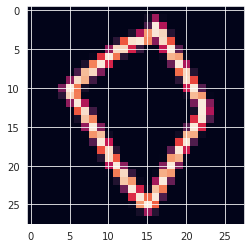

In [15]:
visualise_random(x_train, y_train)

calc PCA.
[0.08513669 0.05221745 0.03973214 0.03500599 0.03106656 0.02375876
 0.01942631 0.01802465 0.01690244 0.01577787]
calc TSNE.


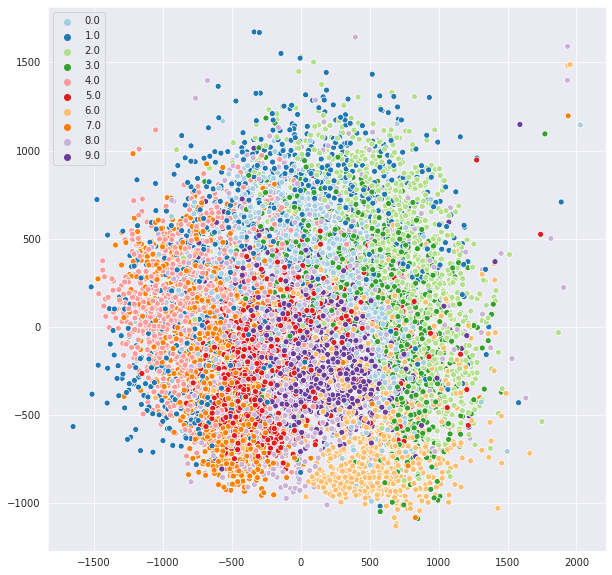

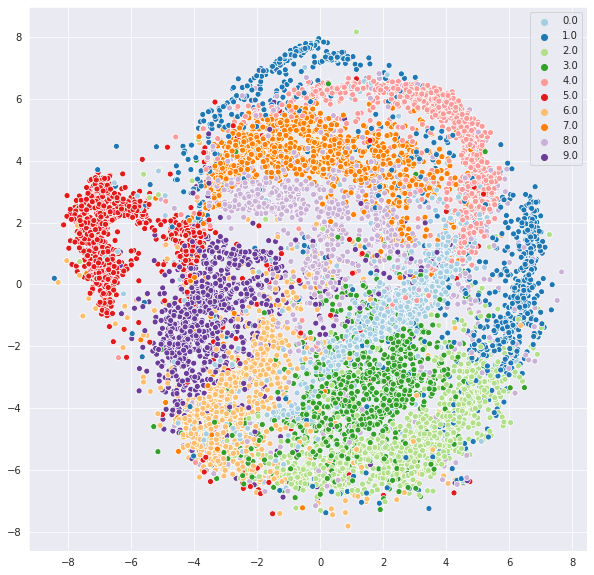

In [56]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from tsnecuda import TSNE

import seaborn as sns
sns.set_style('darkgrid')
palette = sns.color_palette("Paired", 10)
sns.set_palette(palette)

def plot_PCA(X, y):
  print('calc PCA.')
  pca = PCA(n_components=10)
  pca_result = pca.fit_transform(X)
  print(pca.explained_variance_ratio_)

  plt.figure(figsize=(10,10))
  ax = sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y, palette=palette)

  return pca_result

def plot_TSNE(X, y):
  print('calc TSNE.')
  tsne_projections = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X)
  plt.figure(figsize=(10,10))
  ax = sns.scatterplot(tsne_projections[:,0], tsne_projections[:,1], hue=y, palette=palette)

sample_size = 10000

X = np.reshape(x_train, (x_train.shape[0], 28 * 28))[0:sample_size]
y = y_train[0:sample_size]

pca_result = plot_PCA(X, y)
plot_TSNE(X,y)

In [57]:
# !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

In [58]:
# !conda install tsnecuda cuda101 -c cannylab

In [59]:
# import tsnecuda
# print(tsnecuda.test())